In [261]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import pearsonr
from scipy.spatial import distance
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20

pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

Carrega a base de voos

In [262]:
international_flights = pd.read_csv('international_graph.csv')
international_flights = international_flights[['pais_origem', 'pais_destino', 'qtde_voos']]
international_flights = international_flights.set_index(['pais_origem', 'pais_destino'])

Descomentar para testes:

countries_loc = ['Brazil', 'Italy', 'China', 'United States', 'France', 'Germany', 'Iran', 'United Kingdom']
international_flights_loc = pd.DataFrame(columns=['pais_origem', 'pais_destino', 'qtde_voos'])

for index in international_flights.index:
    if index[0] in countries_loc and index[1] in countries_loc:
        df = pd.DataFrame({'pais_origem': [index[0]], 'pais_destino': [index[1]], 'qtde_voos': [float(international_flights.loc[index])]})
        international_flights_loc = international_flights_loc.append(df, ignore_index=True)

international_flights = international_flights_loc.set_index(['pais_origem', 'pais_destino'])

In [263]:
international_flights.head()

qtde_voos
pais_origem pais_destino           
Algeria     Argentina      0.001370
            Austria        0.173973
            Belgium        0.253425
            Brazil         0.021918
            Canada         0.272603

Constrói o vetor de correlação com a média de voos entre os países

In [264]:
international_flights_avg = pd.DataFrame(columns = ['source', 'target', 'value'])
indexes = international_flights.index
international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()


for index in indexes:
    if list(index) not in international_flights_avg_list:
        if (index[1], index[0]) not in indexes:
            value_1 = [[index[0], index[1], international_flights.loc[(index[0], index[1])].qtde_voos]]
            value_2 = [[index[1], index[0], international_flights.loc[(index[0], index[1])].qtde_voos]]
        else:
            base_value =  (international_flights.loc[(index[0], index[1])].qtde_voos + international_flights.loc[(index[1], index[0])].qtde_voos)/2
            value_1 = [[index[0], index[1], base_value]]
            value_2 = [[index[1], index[0], base_value]]

        df = pd.DataFrame(value_1, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True)
        df = pd.DataFrame(value_2, columns=['source', 'target', 'value'])
        international_flights_avg = international_flights_avg.append(df, ignore_index = True) 
        
        international_flights_avg_list = international_flights_avg[['source', 'target']].values.tolist()
        

In [265]:
international_flights_avg.to_csv('transition_matrix_edge_list.csv', index=False)
international_flights_avg.head()

,source,target,value
0,Algeria,Argentina,0.005479
1,Argentina,Algeria,0.005479
2,Algeria,Austria,0.141781
3,Austria,Algeria,0.141781
4,Algeria,Belgium,0.307534


Constrói o grafo com a probabilidade de voos entre países

In [266]:
country_international_flights = international_flights_avg.groupby(['source']).sum() 
transition_matrix = international_flights_avg.copy()
transition_matrix = transition_matrix.drop(columns= ['value'])

transition_matrix['prob'] = 0.

for index, row in international_flights_avg.iterrows():
    weight = float(country_international_flights.loc[row['source']])
    transition_matrix.loc[index,'prob'] = row['value']/weight


In [267]:

transition_matrix.head()

,source,target,prob
0,Algeria,Argentina,0.000300
1,Argentina,Algeria,0.000166
2,Algeria,Austria,0.007769
3,Austria,Algeria,0.000590
4,Algeria,Belgium,0.016851


In [268]:
transition_matrix_crosstab = pd.crosstab(transition_matrix['target'], transition_matrix['source'], transition_matrix['prob'], aggfunc=sum)
transition_matrix_crosstab = transition_matrix_crosstab.fillna(0)

In [269]:
transition_matrix_crosstab

source,Algeria,Anguilla,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Bermuda,Bolivia,Bosnia and Herzegovina,Brazil,British Virgin Islands,Brunei,Bulgaria,Canada,Cape Verde,Chile,China,Colombia,Costa Rica,Croatia,Cyprus,Czech Republic,Denmark,Dominican Republic,Ecuador,Egypt,Estonia,Finland,France,French Polynesia,Gambia,Georgia,Germany,Gibraltar,Greece,Grenada,Guatemala,Guernsey,Guinea,Guinea-Bissau,Haiti,...,New Caledonia,New Zealand,Norway,Oman,Pakistan,Palestine,Panama,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russia,Saint Lucia,Saint Pierre and Miquelon,Saint Vincent and the Grenadines,Saudi Arabia,Senegal,Serbia,Singapore,Slovakia,Slovenia,South Africa,South Korea,Spain,Sri Lanka,Suriname,Sweden,Switzerland,Taiwan,Tajikistan,Thailand,Trinidad and Tobago,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Virgin Islands,West Bank,Western Sahara,Zambia
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algeria,0.000000,0.0,0.000166,0.000000,0.000000,0.000000,0.000590,0.000000,0.000000,0.000128,0.000345,0.000000,0.000000,0.001642,0.0,0.000000,0.000000,0.000000,0.000325,0.000000,0.000000,0.000000,0.000801,0.000000,0.000000,0.000000,0.000245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001887,0.000000,0.000000,0.015935,0.000000,0.000933,0.000000,0.000561,0.000000,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000018,0.000000,0.001307,0.0,0.000000,0.000000,0.000101,0.000000,0.000570,0.000000,0.003217,0.000000,0.000000,0.000244,0.000000,0.000000,0.000000,0.001162,0.028759,0.000077,0.000000,0.000000,0.000000,0.000166,0.000000,0.003552,0.000000,0.000000,0.000013,0.000813,0.000000,0.000000,0.000000,0.000000,0.000816,0.005329,0.000000,0.002236,0.000451,0.000012,0.000307,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Anguilla,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Argentina,0.000300,0.0,0.000000,0.000000,0.000466,0.000675,0.000006,0.000000,0.000000,0.000000,0.002070,0.000000,0.000000,0.000135,0.0,0.000239,0.197832,0.000000,0.180545,0.000000,0.000000,0.000000,0.001356,0.001987,0.208369,0.000000,0.020421,0.006727,0.000000,0.000000,0.000038,0.000000,0.019744,0.064713,0.000000,0.000000,0.000000,0.001056,0.000960,0.000000,0.000000,0.000571,0.000000,0.000019,0.000000,0.003895,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005641,0.000000,0.000000,0.000000,0.0,0.026452,0.098779,0.000081,0.000025,0.000027,0.000897,0.000047,0.017647,0.000000,0.000050,0.000000,0.000000,0.000000,0.000038,0.002801,0.000000,0.000000,0.000000,0.000000,0.000222,0.000029,0.006148,0.000000,0.000000,0.000006,0.000350,0.000000,0.000000,0.000019,0.000000,0.000148,0.000016,0.000000,0.000016,0.000894,0.008633,0.302989,0.000000,0.084052,0.000000,0.000000,0.000000,0.0,0.000000
Armenia,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.001911,0.000011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

Carrega o arquivo com o total diário de casos e pega o dia específico - 77

In [270]:
total_cases = pd.read_csv('total_cases_countries_normalized.csv')
total_cases = total_cases[['Name', 'Day', 'Total']].set_index(['Name', 'Day'])

countries = transition_matrix_crosstab.columns.to_list()

indexes = []
for index in total_cases.index:
    indexes.append(index)

daily_cases = pd.DataFrame(columns=['n_cases'], index=[countries])

for country in countries:
    if (country, 77) not in indexes:
        daily_cases.loc[country, 'n_cases'] = 0. 
    else:
        daily_cases.loc[country, 'n_cases'] = total_cases.loc[country, 77][0]

In [271]:
daily_cases

,n_cases
Algeria,58
Anguilla,0
Argentina,65
Armenia,52
Aruba,2
Australia,375
Austria,1016
Azerbaijan,19
Bahamas,1
Bahrain,221


Faz o random walk

In [272]:
def new_state_df(initial_number, transition_matrix_crosstab):

    state_df = pd.DataFrame(index=transition_matrix_crosstab.columns, columns = ['n_cases'])

    for country in state_df.index:
        if country == 'China':
            state_df.loc[country, 'n_cases'] = float(initial_number)
        else:
            state_df.loc[country, 'n_cases'] = 0.
            
    return state_df


Cria o dataframe a ser utilizado e roda o gridsearch

In [273]:
np.arange(1.,1.5,0.02)

array([1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 ,
       1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42,
       1.44, 1.46, 1.48])

In [274]:
contamination_rate = np.arange(1.01,1.5,0.02)
initial_number = [x for x in range(1500,2510,50)] 
correlation_df = pd.DataFrame(columns=['V', 'R', 'Euclidean Distance'])

def model_spread(v, r):
    state_df = new_state_df(v, transition_matrix_crosstab)
    state_df = transition_matrix_crosstab.dot(state_df)
    for i in range(1, 78):
        state_df = transition_matrix_crosstab.dot(state_df)
        state_df = state_df*r
    return state_df

def model_spread2(v, r, p):
    state_df = new_state_df(v, transition_matrix_crosstab)
#     state_df = transition_matrix_crosstab.dot(state_df)
    for i in range(1, 78):
        state_df = state_df*r + (transition_matrix_crosstab.dot(state_df)*p)
    return state_df

v_min_dist = initial_number[0]
r_min_dist = contamination_rate[0]
min_dist = np.Inf

p = 0.01

for v in initial_number:
    for r in contamination_rate: 
        state_df = model_spread2(v, r, p)
                
        dist_euclidean = distance.euclidean(daily_cases, state_df)
        
        df = pd.DataFrame([{'V': v, 'R': r, 'Euclidean Distance': dist_euclidean}])
        correlation_df = correlation_df.append(df, ignore_index=True)
            
        if abs(dist_euclidean)<abs(min_dist):
            min_dist = dist_euclidean
            v_min_dist = v
            r_min_dist = r
        
print('Menor distancia Euclideana: ' + str(min_dist))
print('V: ' + str(v_min_dist))
print('R: ' + str(r_min_dist))

Menor distancia Euclideana: 38315.22379562062
V: 1800
R: 1.05


In [275]:
state_df_final = model_spread2(v_min_dist, r_min_dist, p)

print(state_df_final.sum())

state_df_final

n_cases    159891.041151
dtype: float64


,n_cases
source,
Algeria,10.8686
Anguilla,0.000523774
Argentina,24.4506
Armenia,2.21284
Aruba,3.66705
Australia,2767.24
Austria,448.859
Azerbaijan,0.294835
Bahamas,3.27443


In [276]:
print(daily_cases.sum())

daily_cases

n_cases    183806.0
dtype: float64


,n_cases
Algeria,58
Anguilla,0
Argentina,65
Armenia,52
Aruba,2
Australia,375
Austria,1016
Azerbaijan,19
Bahamas,1
Bahrain,221


In [277]:
pearsonr(state_df_final.T.values[0], daily_cases.T.values[0])

(0.9002751341274875, 2.0249266087455408e-52)

In [278]:
correlation_pivot = correlation_df.pivot(index='V', columns='R', values='Euclidean Distance')
correlation_pivot

R,1.01,1.03,1.05,1.07,1.09,1.11,1.13,1.15,1.17,1.19,1.21,1.23,1.25,1.27,1.29,1.31,1.33,1.35,1.37,1.39,1.41,1.43,1.45,1.47,1.49
V,,,,,,,,,,,,,,,,,,,,,,,,,
1500,86212.567871,75788.177303,40723.563591,207926.876573,1.104334e+06,4.715119e+06,1.885997e+07,7.294900e+07,2.750397e+08,1.013377e+09,3.653100e+09,1.289510e+10,4.460321e+10,1.512754e+11,5.033824e+11,1.644407e+12,5.276484e+12,1.663930e+13,5.159433e+13,1.573827e+14,4.725013e+14,1.396799e+15,4.067576e+15,1.167312e+16,3.302621e+16
1550,86112.162725,75351.456524,40023.739725,217274.132242,1.143791e+06,4.874972e+06,1.949133e+07,7.538333e+07,2.842104e+08,1.047159e+09,3.774873e+09,1.332494e+10,4.608998e+10,1.563179e+11,5.201618e+11,1.699221e+12,5.452366e+12,1.719394e+13,5.331414e+13,1.626288e+14,4.882513e+14,1.443359e+15,4.203162e+15,1.206222e+16,3.412709e+16
1600,86011.787054,74915.625815,39437.345969,226634.238755,1.183250e+06,5.034825e+06,2.012269e+07,7.781765e+07,2.933811e+08,1.080941e+09,3.896646e+09,1.375478e+10,4.757676e+10,1.613604e+11,5.369413e+11,1.754034e+12,5.628249e+12,1.774859e+13,5.503395e+13,1.678749e+14,5.040014e+14,1.489919e+15,4.338748e+15,1.245133e+16,3.522796e+16
1650,85911.440964,74480.700802,38969.503181,236005.667105,1.222710e+06,5.194679e+06,2.075405e+07,8.025198e+07,3.025518e+08,1.114723e+09,4.018418e+09,1.418462e+10,4.906353e+10,1.664029e+11,5.537207e+11,1.808848e+12,5.804132e+12,1.830323e+13,5.675376e+13,1.731210e+14,5.197514e+14,1.536479e+15,4.474333e+15,1.284043e+16,3.632884e+16
1700,85811.124557,74046.697445,38624.519476,245387.120139,1.262172e+06,5.354533e+06,2.138540e+07,8.268631e+07,3.117225e+08,1.148504e+09,4.140191e+09,1.461446e+10,5.055031e+10,1.714454e+11,5.705001e+11,1.863662e+12,5.980015e+12,1.885787e+13,5.847357e+13,1.783671e+14,5.355014e+14,1.583039e+15,4.609919e+15,1.322953e+16,3.742971e+16
1750,85710.837937,73613.632044,38405.705786,254777.490468,1.301634e+06,5.514387e+06,2.201676e+07,8.512064e+07,3.208931e+08,1.182286e+09,4.261964e+09,1.504429e+10,5.203709e+10,1.764880e+11,5.872795e+11,1.918475e+12,6.155897e+12,1.941252e+13,6.019338e+13,1.836132e+14,5.512515e+14,1.629599e+15,4.745505e+15,1.361864e+16,3.853058e+16
1800,85610.581210,73181.521251,38315.223796,264175.827174,1.341098e+06,5.674242e+06,2.264812e+07,8.755497e+07,3.300638e+08,1.216068e+09,4.383736e+09,1.547413e+10,5.352386e+10,1.815305e+11,6.040589e+11,1.973289e+12,6.331780e+12,1.996716e+13,6.191319e+13,1.888593e+14,5.670015e+14,1.676158e+15,4.881091e+15,1.400774e+16,3.963146e+16
1850,85510.354479,72750.382076,38353.981770,273581.309251,1.380562e+06,5.834096e+06,2.327948e+07,8.998930e+07,3.392345e+08,1.249850e+09,4.505509e+09,1.590397e+10,5.501064e+10,1.865730e+11,6.208383e+11,2.028102e+12,6.507663e+12,2.052180e+13,6.363300e+13,1.941054e+14,5.827516e+14,1.722718e+15,5.016677e+15,1.439685e+16,4.073233e+16
1900,85410.157852,72320.231896,38521.589613,282993.224257,1.420028e+06,5.993951e+06,2.391084e+07,9.242362e+07,3.484052e+08,1.283632e+09,4.627282e+09,1.633381e+10,5.649741e+10,1.916155e+11,6.376178e+11,2.082916e+12,6.683546e+12,2.107645e+13,6.535282e+13,1.993515e+14,5.985016e+14,1.769278e+15,5.152263e+15,1.478595e+16,4.183321e+16


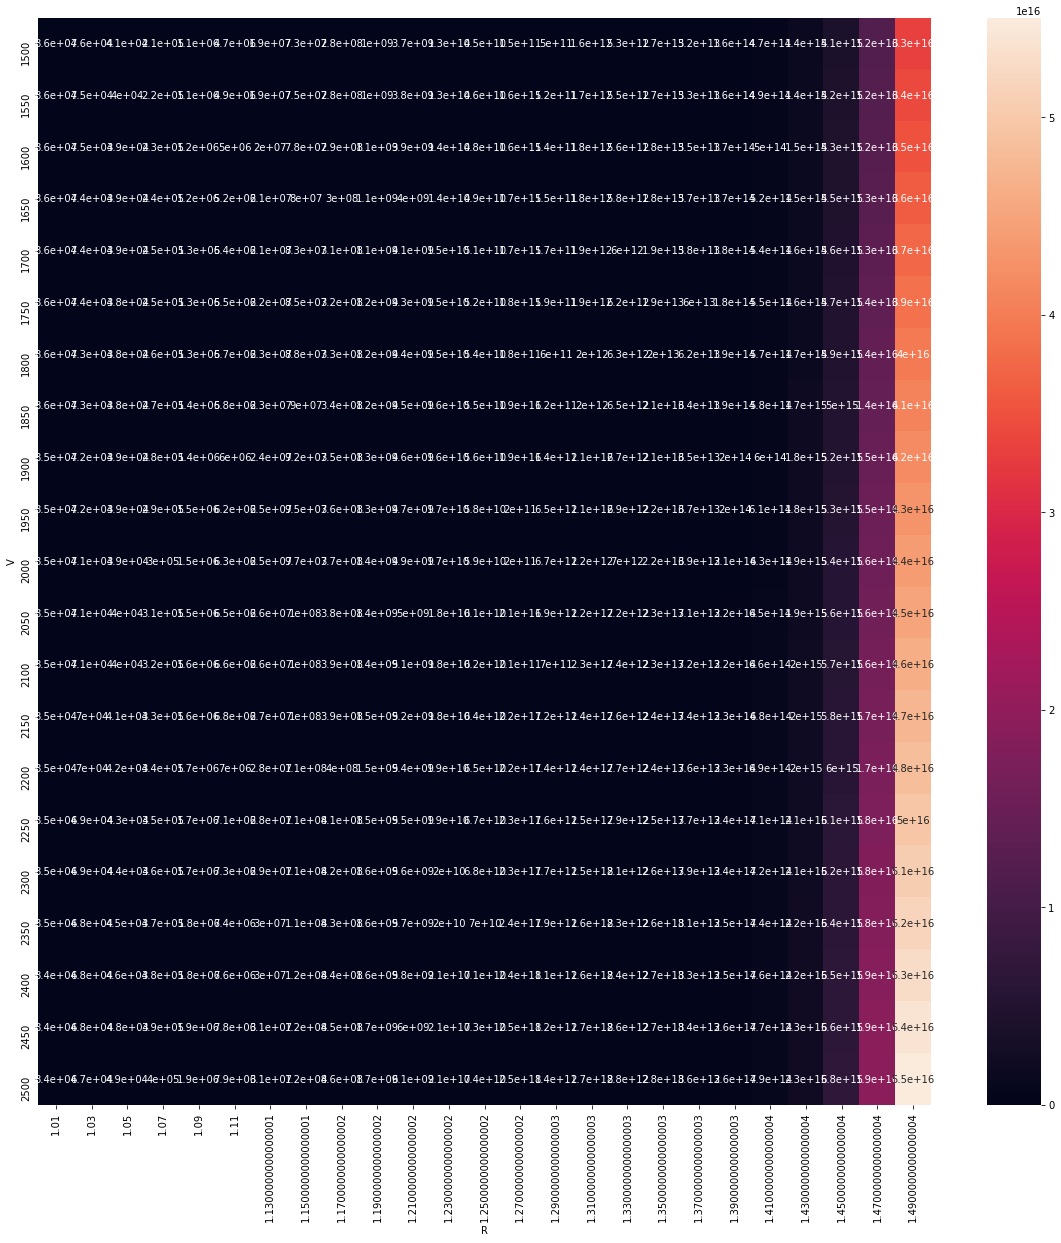

In [279]:
heatmap = sns.heatmap(correlation_pivot, annot=True)

In [280]:
state_df = new_state_df(10, transition_matrix_crosstab)

for i in range(78):
    if i == 0:
        state_df = transition_matrix_crosstab.dot(state_df)
    else:
        state_df = transition_matrix_crosstab.dot(state_df)
        state_df = state_df*1.1
        
state_df.to_csv('state_vector.csv')

In [281]:
state_df.head()

,n_cases
target,
Algeria,24.3579
Anguilla,0.00182826
Argentina,43.9595
Armenia,1.44341
Aruba,3.9271
